## Gaussian mixture clustering

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from stepmix.stepmix import StepMix
from load_clustering_data import load_data_for_clustering


DATA_PATH = "../../data/preprocessed_flight_data.csv"


X_delayed = load_data_for_clustering(filter_for_delays=True)
print("\nData loaded successfully for clustering:")
print(X_delayed.head())

Loading data from: ../../data/preprocessed_flight_data.csv
Filtering for delayed flights (where is_arr_delayed == 1)...
Found 2522008 delayed flights.
Filtering for delayed flights (where is_arr_delayed == 1)...
Found 2522008 delayed flights.

Data loaded successfully for clustering:
    month  day_of_month  day_of_week op_unique_carrier origin dest
13      1             1            1                9E    GRR  DTW
21      1             1            1                9E    MIA  RDU
22      1             1            1                9E    RDU  MIA
39      1             1            1                9E    DHN  ATL
54      1             1            1                9E    CLT  JFK

Data loaded successfully for clustering:
    month  day_of_month  day_of_week op_unique_carrier origin dest
13      1             1            1                9E    GRR  DTW
21      1             1            1                9E    MIA  RDU
22      1             1            1                9E    RDU  MIA
39 

In [2]:
print("\nEncoding data...")
X_encoded = pd.DataFrame()
encoders = {}

for col in X_delayed.columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_delayed[col])
    encoders[col] = le

print("Data encoded successfully:")
print(X_encoded.head())


Encoding data...
Data encoded successfully:
   month  day_of_month  day_of_week  op_unique_carrier  origin  dest
0      0             0            0                  0     136    98
1      0             0            0                  0     216   272
2      0             0            0                  0     272   216
3      0             0            0                  0      92    20
4      0             0            0                  0      69   173
Data encoded successfully:
   month  day_of_month  day_of_week  op_unique_carrier  origin  dest
0      0             0            0                  0     136    98
1      0             0            0                  0     216   272
2      0             0            0                  0     272   216
3      0             0            0                  0      92    20
4      0             0            0                  0      69   173


### Autoencoder + Gaussian Mixture Plan
To run latent class analysis with a Gaussian Mixture on categorical flight-delay features we will:

1. Estimate a safe sample size for GPU-bound autoencoder training based on RTX 5070 Mobile (8–12 GB VRAM assumed) and 32 GB system RAM.
2. Encode every categorical column as integer IDs (already done) and feed them to a small embedding-based autoencoder built in PyTorch with CUDA acceleration when available.
3. Train the autoencoder on the sampled subset, extract its latent space, scale those latent vectors, and fit a GaussianMixture model to obtain soft clusters.
4. Report cluster diagnostics (BIC/AIC, mixture weights, counts) so we can compare against the earlier StepMix workflow.

In [3]:
import torch
from typing import Dict


GPU_VRAM_GB = 8
SYSTEM_RAM_GB = 32
GPU_SAFETY_FRACTION = 0.6
RAM_SAFETY_FRACTION = 0.7

feature_cardinalities: Dict[str, int] = {
    col: len(encoders[col].classes_)
    for col in X_delayed.columns
}

embedding_dims: Dict[str, int] = {
    col: int(min(64, max(4, cardinality // 2)))
    for col, cardinality in feature_cardinalities.items()
}

sum_embed_dim = sum(embedding_dims.values())
bytes_per_latent_sample = sum_embed_dim * 4 * 3  # forward + backward + optimizer states (rough heuristic)
available_gpu_bytes = GPU_VRAM_GB * (1024 ** 3) * GPU_SAFETY_FRACTION
max_samples_gpu = int(available_gpu_bytes / bytes_per_latent_sample)

# CPU memory guard: int32 encoded features + replication buffers
bytes_per_row_cpu = len(X_delayed.columns) * 4 * 2
available_ram_bytes = SYSTEM_RAM_GB * (1024 ** 3) * RAM_SAFETY_FRACTION
max_samples_ram = int(available_ram_bytes / bytes_per_row_cpu)

suggested_sample_size = min(len(X_encoded), max_samples_gpu, max_samples_ram)
suggested_sample_size = max(50_000, suggested_sample_size)  # keep a reasonable floor

print(f"Total rows available: {len(X_encoded):,}")
print(f"Sum embedding dim: {sum_embed_dim}")
print(f"GPU-limited sample cap: {max_samples_gpu:,}")
print(f"RAM-limited sample cap: {max_samples_ram:,}")
print(f"Suggested sample size: {suggested_sample_size:,}")

Total rows available: 2,522,008
Sum embedding dim: 160
GPU-limited sample cap: 2,684,354
RAM-limited sample cap: 501,079,517
Suggested sample size: 2,522,008


In [4]:
AUTOENCODER_SAMPLE_SIZE = min(len(X_encoded), suggested_sample_size)

if len(X_encoded) > AUTOENCODER_SAMPLE_SIZE:
    print(f"Sampling {AUTOENCODER_SAMPLE_SIZE:,} rows out of {len(X_encoded):,} for autoencoder training...")
    X_auto = X_encoded.sample(n=AUTOENCODER_SAMPLE_SIZE, random_state=42).reset_index(drop=True)
else:
    print("Using the full dataset for autoencoder training.")
    X_auto = X_encoded.reset_index(drop=True)

print(f"Autoencoder dataset shape: {X_auto.shape}")

Using the full dataset for autoencoder training.
Autoencoder dataset shape: (2522008, 6)


In [5]:
from torch.utils.data import DataLoader, TensorDataset, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

categorical_cols = list(X_auto.columns)
encoded_tensor = torch.tensor(X_auto.values, dtype=torch.long)
dataset = TensorDataset(encoded_tensor)

train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

BATCH_SIZE = 2048
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=(device.type == 'cuda'))
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=(device.type == 'cuda'))
full_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=(device.type == 'cuda'))

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Using device: cuda
Train batches: 986, Val batches: 247
Train batches: 986, Val batches: 247


In [6]:
import math
from torch import nn

class CategoricalAutoencoder(nn.Module):
    def __init__(self, cardinalities: Dict[str, int], embedding_dims: Dict[str, int], latent_dim: int = 32, hidden_dim: int = 128):
        super().__init__()
        self.columns = list(cardinalities.keys())
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=cardinalities[col], embedding_dim=embedding_dims[col])
            for col in self.columns
        ])
        embed_total = sum(embedding_dims.values())

        self.encoder = nn.Sequential(
            nn.Linear(embed_total, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        self.decoder = nn.ModuleList([
            nn.Linear(latent_dim, cardinalities[col])
            for col in self.columns
        ])

    def forward(self, x: torch.Tensor):
        embeds = []
        for idx, emb in enumerate(self.embeddings):
            embeds.append(emb(x[:, idx]))
        h = torch.cat(embeds, dim=1)
        z = self.encoder(h)
        logits = [decoder(z) for decoder in self.decoder]
        return logits, z

In [7]:
LATENT_DIM = 32
HIDDEN_DIM = 128
EPOCHS = 10
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

model = CategoricalAutoencoder(feature_cardinalities, embedding_dims, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
best_state = None

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    for (batch,) in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits, _ = model(batch)
        loss = sum(criterion(logit, batch[:, idx]) for idx, logit in enumerate(logits)) / len(logits)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (batch,) in val_loader:
            batch = batch.to(device)
            logits, _ = model(batch)
            loss = sum(criterion(logit, batch[:, idx]) for idx, logit in enumerate(logits)) / len(logits)
            val_loss += loss.item() * batch.size(0)

    train_loss /= len(train_ds)
    val_loss /= len(val_ds)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict()

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

if best_state:
    model.load_state_dict(best_state)
    print(f"Restored best model with val loss {best_val_loss:.4f}")

Epoch 01 | Train Loss: 0.4262 | Val Loss: 0.0186
Epoch 02 | Train Loss: 0.0139 | Val Loss: 0.0118
Epoch 02 | Train Loss: 0.0139 | Val Loss: 0.0118
Epoch 03 | Train Loss: 0.0110 | Val Loss: 0.0105
Epoch 03 | Train Loss: 0.0110 | Val Loss: 0.0105
Epoch 04 | Train Loss: 0.0102 | Val Loss: 0.0099
Epoch 04 | Train Loss: 0.0102 | Val Loss: 0.0099
Epoch 05 | Train Loss: 0.0098 | Val Loss: 0.0097
Epoch 05 | Train Loss: 0.0098 | Val Loss: 0.0097
Epoch 06 | Train Loss: 0.0095 | Val Loss: 0.0094
Epoch 06 | Train Loss: 0.0095 | Val Loss: 0.0094
Epoch 07 | Train Loss: 0.0093 | Val Loss: 0.0093
Epoch 07 | Train Loss: 0.0093 | Val Loss: 0.0093
Epoch 08 | Train Loss: 0.0092 | Val Loss: 0.0092
Epoch 08 | Train Loss: 0.0092 | Val Loss: 0.0092
Epoch 09 | Train Loss: 0.0091 | Val Loss: 0.0091
Epoch 09 | Train Loss: 0.0091 | Val Loss: 0.0091
Epoch 10 | Train Loss: 0.0091 | Val Loss: 0.0092
Restored best model with val loss 0.0091
Epoch 10 | Train Loss: 0.0091 | Val Loss: 0.0092
Restored best model with val

In [8]:
model.eval()
latent_chunks = []
with torch.no_grad():
    for (batch,) in full_loader:
        batch = batch.to(device)
        _, z = model(batch)
        latent_chunks.append(z.cpu())

latent_tensor = torch.cat(latent_chunks)
latent_df = pd.DataFrame(latent_tensor.numpy(), columns=[f"latent_{i}" for i in range(LATENT_DIM)])
print(latent_df.head())

   latent_0  latent_1   latent_2   latent_3  latent_4  latent_5  latent_6  \
0 -6.859598 -0.877723   0.100676  -0.717262 -4.735457 -1.418847 -0.763846   
1 -2.797803  1.751130   6.342068   3.495506  1.186037  2.048973 -3.476272   
2 -9.092538 -0.534513   7.028745  -0.084925 -2.835401 -3.818660 -1.482990   
3 -1.665148  2.476906   3.495260   6.663893 -3.504858 -1.847831  7.905583   
4  4.017343 -1.196119  12.143124  10.465673 -1.912481 -4.352511 -8.555914   

   latent_7   latent_8  latent_9  ...  latent_22  latent_23  latent_24  \
0  8.217154   5.060114 -0.001456  ...  -6.355450   1.862656 -11.720089   
1  0.281320  12.781468 -5.760817  ...  -4.529530   1.093875  -3.185323   
2  4.916868   1.879358  1.886493  ...  -2.179732   2.188876 -13.009584   
3  5.785673   0.469722 -5.631750  ...  -1.971102   0.008185  -0.272118   
4  2.053439   8.327590 -0.692310  ...  -6.152607   7.214769  -4.982323   

   latent_25  latent_26  latent_27  latent_28  latent_29  latent_30  latent_31  
0   4.27384

#### Limiting GMM training rows
Set `GMM_SAMPLE_TARGET` to the maximum number of latent rows you want the Gaussian Mixture to see (default 1,000,000). The code above samples without replacement and keeps a matching slice of the original categorical rows so downstream summaries stay aligned.

In [9]:
latent_for_gmm = latent_df.copy()
X_auto_for_gmm = X_auto.reset_index(drop=True)


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

latent_scaled = StandardScaler().fit_transform(latent_for_gmm.values)

N_COMPONENTS = 6
GMM_MAX_ITER = 100

gmm = GaussianMixture(
    n_components=N_COMPONENTS,
    covariance_type='diag',
    random_state=42,
    n_init=5,
    max_iter=GMM_MAX_ITER,
    verbose=1
)

cluster_labels = gmm.fit_predict(latent_scaled)
cluster_probs = gmm.predict_proba(latent_scaled)

SIL_SAMPLE_SIZE = 10_000
if len(latent_scaled) > SIL_SAMPLE_SIZE:
    print(f"Sampling {SIL_SAMPLE_SIZE:,} rows for silhouette score calculation...")
    sil_sample_indices = latent_for_gmm.sample(n=SIL_SAMPLE_SIZE, random_state=42).index
    sil_sample = latent_scaled[sil_sample_indices]
    sil_labels = cluster_labels[sil_sample_indices]
else:
    sil_sample = latent_scaled
    sil_labels = cluster_labels

sil_score = silhouette_score(sil_sample, sil_labels) if N_COMPONENTS > 1 else float('nan')
print(f"GMM converged: {gmm.converged_} in {gmm.n_iter_} iterations")
print(f"AIC: {gmm.aic(latent_scaled):,.0f} | BIC: {gmm.bic(latent_scaled):,.0f}")
print(f"Silhouette score: {sil_score:.4f}")

Initialization 0
Initialization converged.
Initialization 1
Initialization converged.
Initialization 1
Initialization converged.
Initialization 2
Initialization converged.
Initialization 2
Initialization converged.
Initialization 3
Initialization converged.
Initialization 3
Initialization converged.
Initialization 4
Initialization converged.
Initialization 4
Initialization converged.
Initialization converged.
Sampling 10,000 rows for silhouette score calculation...
Sampling 10,000 rows for silhouette score calculation...
GMM converged: True in 6 iterations
GMM converged: True in 6 iterations
AIC: 219,790,262 | BIC: 219,795,218
Silhouette score: 0.0572
AIC: 219,790,262 | BIC: 219,795,218
Silhouette score: 0.0572


In [11]:
cluster_summary = pd.Series(cluster_labels).value_counts().sort_index().rename('count')
cluster_summary = cluster_summary.to_frame()
cluster_summary['weight_%'] = (cluster_summary['count'] / len(cluster_labels)) * 100
cluster_summary['gmm_weight'] = gmm.weights_

print("\nCluster distribution:")
print(cluster_summary)

clustered_data = X_auto_for_gmm.copy()
clustered_data['cluster'] = cluster_labels
clustered_data.head()


Cluster distribution:
    count   weight_%  gmm_weight
0  370742  14.700271    0.148253
1  659565  26.152375    0.257858
2  338372  13.416769    0.135092
3  636982  25.256938    0.254860
4  385227  15.274615    0.152115
5  131120   5.199032    0.051822


,month,day_of_month,day_of_week,op_unique_carrier,origin,dest,cluster
0,0,0,0,0,136,98,3
1,0,0,0,0,216,272,3
2,0,0,0,0,272,216,0
3,0,0,0,0,92,20,4
4,0,0,0,0,69,173,0


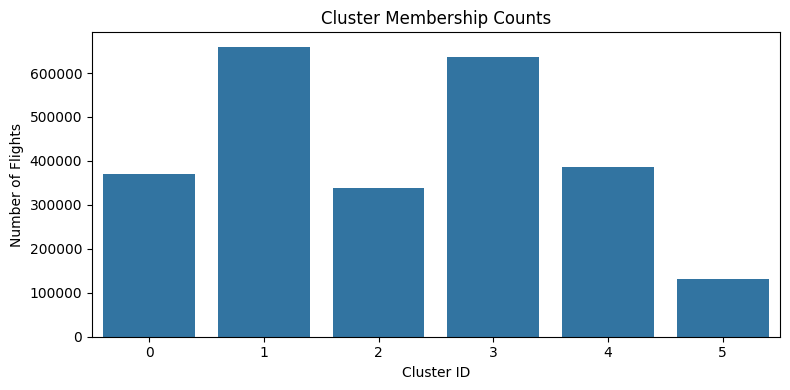

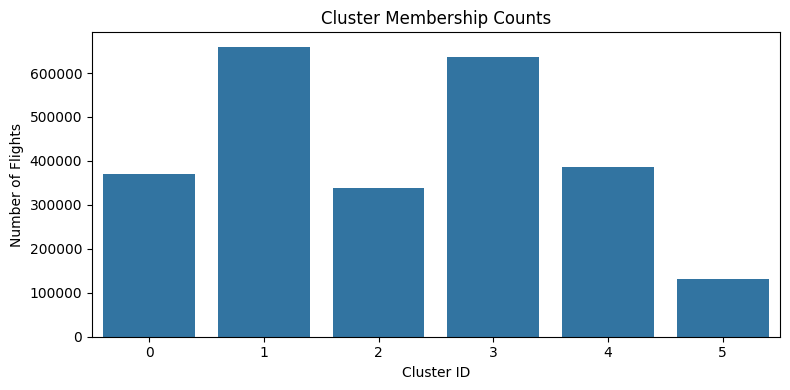

/tmp/ipykernel_14340/3280325101.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


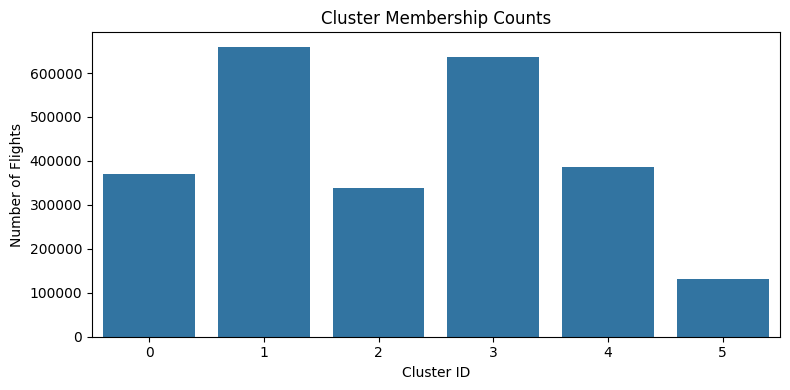

/tmp/ipykernel_14340/3280325101.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


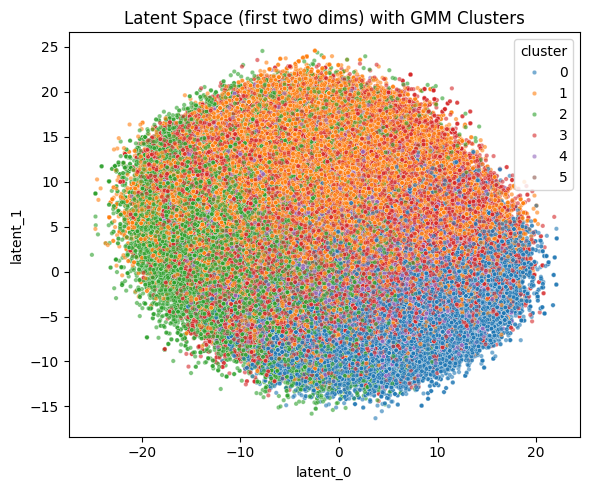

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.barplot(x=cluster_summary.index, y='count', data=cluster_summary.reset_index())
plt.title('Cluster Membership Counts')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Flights')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
scatter_df = latent_for_gmm.copy()
scatter_df['cluster'] = cluster_labels
sns.scatterplot(data=scatter_df, x='latent_0', y='latent_1', hue='cluster', palette='tab10', s=10, alpha=0.6)
plt.title('Latent Space (first two dims) with GMM Clusters')
plt.tight_layout()
plt.show()

### Hyperparameter Tuning for Gaussian Mixture

In [15]:
from sklearn.model_selection import ParameterSampler
from IPython.display import display
from tqdm.auto import tqdm
import numpy as np


param_distributions = {
    "n_components": np.arange(2, 16, dtype=int),
    "covariance_type": ["full", "tied", "diag", "spherical"],
    "reg_covar": np.logspace(-6, -2, num=20),
    "n_init": [1, 2, 5, 10],
    "init_params": ["kmeans", "random"],
}

N_SEARCH_ITER = 20
RANDOM_STATE = 42
TUNING_SAMPLE_SIZE = min(len(latent_scaled), 100_000)

rng = np.random.default_rng(RANDOM_STATE)
tuning_indices = rng.choice(len(latent_scaled), size=TUNING_SAMPLE_SIZE, replace=False)
latent_tuning = latent_scaled[tuning_indices]

print(f"Running randomized search on a subset of {TUNING_SAMPLE_SIZE:,} latent rows (out of {len(latent_scaled):,})")

search_records = []
param_iter = ParameterSampler(param_distributions, n_iter=N_SEARCH_ITER, random_state=RANDOM_STATE)
for params in tqdm(param_iter, total=N_SEARCH_ITER, desc="Tuning GMM"):
    gm_trial = GaussianMixture(
        n_components=int(params["n_components"]),
        covariance_type=params["covariance_type"],
        reg_covar=float(params["reg_covar"]),
        n_init=int(params["n_init"]),
        init_params=params["init_params"],
        max_iter=GMM_MAX_ITER,
        random_state=RANDOM_STATE,
    )
    gm_trial.fit(latent_tuning)
    labels_trial = gm_trial.predict(latent_tuning)
    sil_subset = (
        silhouette_score(latent_tuning, labels_trial)
        if params["n_components"] > 1
        else float("nan")
    )
    search_records.append({
        **params,
        "bic": gm_trial.bic(latent_tuning),
        "aic": gm_trial.aic(latent_tuning),
        "avg_log_likelihood": gm_trial.score(latent_tuning),
        "silhouette": sil_subset,
    })

search_results = (
    pd.DataFrame(search_records)
    .sort_values("bic")
    .reset_index(drop=True)
)

print("Top configurations ranked by BIC (lower is better):")
display(search_results.head(10))

best_bic_params = search_results.loc[0, [
    "n_components",
    "covariance_type",
    "reg_covar",
    "n_init",
    "init_params",
]].to_dict()

valid_silhouette = search_results[search_results["silhouette"].notna()]
if not valid_silhouette.empty:
    best_silhouette_params = (
        valid_silhouette.sort_values("silhouette", ascending=False)
        .iloc[0][[
            "n_components",
            "covariance_type",
            "reg_covar",
            "n_init",
            "init_params",
            "silhouette",
        ]]
    )
    print("\nBest configuration by silhouette score (subset evaluation):")
    print(best_silhouette_params)
else:
    best_silhouette_params = None

selected_params = best_bic_params.copy()
print("\nSelected parameters for final model (BIC-optimal):")
print(selected_params)

Running randomized search on a subset of 100,000 latent rows (out of 2,522,008)


Tuning GMM: 100%|██████████| 20/20 [39:35<00:00, 118.76s/it] 

Top configurations ranked by BIC (lower is better):


,reg_covar,n_init,n_components,init_params,covariance_type,bic,aic,avg_log_likelihood,silhouette
0,0.000001,10,12,kmeans,full,4.055817e+06,3.991785e+06,-19.891617,0.033299
1,0.000078,5,11,kmeans,full,4.739540e+06,4.680845e+06,-23.342526,0.047256
2,0.000018,10,7,kmeans,full,4.909286e+06,4.871938e+06,-24.320432,0.034164
3,0.000007,10,2,random,full,6.469942e+06,6.459278e+06,-32.285181,0.030412
4,0.000011,2,2,random,tied,6.765790e+06,6.760149e+06,-33.794816,0.024159
5,0.000011,1,9,random,full,6.814921e+06,6.766900e+06,-33.784021,-0.007915
6,0.000018,2,15,random,tied,6.818941e+06,6.809219e+06,-34.035873,-0.005337
7,0.000546,2,4,kmeans,tied,7.089271e+06,7.083002e+06,-35.408422,0.048983
8,0.006158,5,15,kmeans,diag,8.425913e+06,8.416647e+06,-42.073497,0.070113
9,0.000127,2,13,kmeans,diag,8.467934e+06,8.459905e+06,-42.291087,0.070726



Best configuration by silhouette score (subset evaluation):
n_components             13
covariance_type        diag
reg_covar          0.000127
n_init                    2
init_params          kmeans
silhouette         0.070726
Name: 9, dtype: object

Selected parameters for final model (BIC-optimal):
{'n_components': 12, 'covariance_type': 'full', 'reg_covar': 1e-06, 'n_init': 10, 'init_params': 'kmeans'}


In [21]:
# selected_params = best_silhouette_params.copy()
selected_params = best_bic_params.copy()

### Tuned GMM Diagnostics

In [ ]:
import numpy as np


EVAL_SAMPLE_SIZE = min(len(latent_scaled), 1_000_000)
print(f"Fitting final GMM on {EVAL_SAMPLE_SIZE:,} samples (subsample of full latent set)")

eval_rng = np.random.default_rng(RANDOM_STATE)
eval_indices = eval_rng.choice(len(latent_scaled), size=EVAL_SAMPLE_SIZE, replace=False)
latent_eval_for_fit = latent_scaled[eval_indices]

gmm_tuned = GaussianMixture(
    n_components=int(selected_params["n_components"]),
    covariance_type=selected_params["covariance_type"],
    reg_covar=float(selected_params["reg_covar"]),
    n_init=int(selected_params["n_init"]),
    init_params=selected_params["init_params"],
    max_iter=GMM_MAX_ITER,
    random_state=RANDOM_STATE,
    verbose=1,
)

gmm_tuned.fit(latent_eval_for_fit)

best_cluster_labels = gmm_tuned.predict(latent_scaled)
best_cluster_probs = gmm_tuned.predict_proba(latent_scaled)

aic_eval = gmm_tuned.aic(latent_eval_for_fit)
bic_eval = gmm_tuned.bic(latent_eval_for_fit)

sil_subset_size = min(len(latent_scaled), 50_000)
sil_rng = np.random.default_rng(RANDOM_STATE + 1)
silhouette_indices = sil_rng.choice(len(latent_scaled), size=sil_subset_size, replace=False)

silhouette_subset = (
    silhouette_score(latent_scaled[silhouette_indices], best_cluster_labels[silhouette_indices])
    if int(selected_params["n_components"]) > 1
    else float("nan")
)

print(f"Tuned GMM converged: {gmm_tuned.converged_} in {gmm_tuned.n_iter_} iterations")
print(f"AIC (on {EVAL_SAMPLE_SIZE:,} samples): {aic_eval:,.0f} | BIC (on {EVAL_SAMPLE_SIZE:,} samples): {bic_eval:,.0f}")
print(f"Silhouette score (50k subset): {silhouette_subset:.4f}")

labels_eval = best_cluster_labels[eval_indices]
cluster_summary_eval = (
    pd.Series(labels_eval).value_counts().sort_index().rename('count').to_frame()
)
cluster_summary_eval['weight_%'] = (cluster_summary_eval['count'] / len(labels_eval)) * 100
cluster_summary_eval['gmm_weight'] = gmm_tuned.weights_

print("\nCluster distribution (on evaluation subset used for fit):")
display(cluster_summary_eval)

cluster_summary_full = (
    pd.Series(best_cluster_labels).value_counts().sort_index().rename('count').to_frame()
)
cluster_summary_full['weight_%'] = (cluster_summary_full['count'] / len(best_cluster_labels)) * 100
cluster_summary_full['gmm_weight'] = gmm_tuned.weights_

print("\nCluster distribution (predicted for full dataset):")
display(cluster_summary_full)

Initialization 0
  Iteration 10
  Iteration 10
  Iteration 20
  Iteration 20


KeyboardInterrupt: 

### Cluster Interpretation Helpers

In [ ]:
clustered_data_tuned = X_auto_for_gmm.copy()
clustered_data_tuned["cluster"] = best_cluster_labels


overall_distributions = {
    col: X_auto_for_gmm[col].value_counts(normalize=True)
    for col in X_auto_for_gmm.columns
}

profile_rows = []
for cluster_id, subset in clustered_data_tuned.groupby("cluster"):
    cluster_size = len(subset)
    for col in X_auto_for_gmm.columns:
        cluster_counts = subset[col].value_counts(normalize=True)
        top_code = cluster_counts.index[0]
        top_share = cluster_counts.iloc[0]
        overall_share = overall_distributions[col].get(top_code, 0.0)
        top_label = encoders[col].classes_[top_code]
        profile_rows.append({
            "cluster": cluster_id,
            "feature": col,
            "top_category": top_label,
            "cluster_share": float(top_share),
            "overall_share": float(overall_share),
            "lift": float(top_share - overall_share),
            "cluster_size": cluster_size,
        })

cluster_drivers = pd.DataFrame(profile_rows)
top_drivers = (
    cluster_drivers.sort_values(["cluster", "lift"], ascending=[True, False])
    .groupby("cluster")
    .head(5)
    .reset_index(drop=True)
)

print("Top feature/category drivers per cluster (lift = cluster_share - overall_share):")
display(top_drivers)

latent_centroids = (
    latent_for_gmm.assign(cluster=best_cluster_labels)
    .groupby("cluster")
    .mean()
)
print("\nLatent space centroids per cluster:")
display(latent_centroids)

Top feature/category drivers per cluster (lift = cluster_share - overall_share):


,cluster,feature,top_category,cluster_share,overall_share,lift,cluster_size
0,0,dest,DFW,0.999892,0.047999,0.951894,120775
1,0,op_unique_carrier,AA,0.544939,0.160478,0.384461,120775
2,0,day_of_month,8,0.040787,0.034149,0.006637,120775
3,0,month,7,0.115090,0.111123,0.003967,120775
4,0,day_of_week,5,0.156696,0.162594,-0.005898,120775
...,...,...,...,...,...,...,...
60,12,origin,ORD,0.990922,0.042804,0.948118,103105
61,12,op_unique_carrier,UA,0.317890,0.101205,0.216684,103105
62,12,dest,LGA,0.038019,0.019990,0.018030,103105
63,12,month,5,0.111314,0.101768,0.009546,103105



Latent space centroids per cluster:


,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,...,latent_22,latent_23,latent_24,latent_25,latent_26,latent_27,latent_28,latent_29,latent_30,latent_31
cluster,,,,,,,,,,,,,,,,,,,,,
0,-2.095339,4.843037,7.726408,7.184052,-1.045682,4.943976,4.270086,7.826626,-9.090644,-1.511852,...,-0.572957,0.072784,3.922225,-2.925604,2.943892,5.748211,3.859804,-0.382694,2.543731,6.222602
1,3.799988,-2.281741,7.142208,5.944738,3.739325,-2.691431,-5.705403,9.500124,2.599518,1.633582,...,-6.400281,1.834473,-5.705015,1.440965,1.475033,0.777124,-2.389027,-1.929196,0.805116,-0.316592
2,0.761717,3.511115,4.462409,0.988211,1.707014,0.900904,2.587302,3.387624,1.171739,4.291770,...,0.895533,-2.385466,-0.359913,-1.548669,1.692532,3.343017,2.423553,3.290368,0.385300,1.307897
3,0.600233,3.276407,4.602587,5.488485,-5.603655,-2.759145,6.618132,7.944424,-0.912799,-0.568392,...,-4.526957,-1.363025,-0.867303,-3.590322,2.595160,-5.083172,3.705771,-1.595251,1.558853,1.234885
4,0.911429,3.640038,3.199266,1.724579,-4.932741,-1.272354,-0.576979,7.653871,3.833596,4.727671,...,-4.907428,-2.724682,-3.982479,0.535874,3.001769,-2.367652,0.427195,1.548925,-0.303866,1.499326
5,-2.394266,9.411960,1.259782,-5.124506,3.552865,-2.854597,2.485126,4.027524,5.414433,-0.253769,...,-4.892877,-4.359741,3.193555,-0.929751,0.724822,4.663024,-0.607304,0.556450,-4.984349,5.364517
6,-3.799062,3.270296,4.269463,-5.043513,1.247585,-1.860718,2.324486,2.438635,-2.305967,-2.980901,...,-3.443176,0.889013,2.492955,-0.611124,-3.175334,0.478271,0.635061,-0.449648,1.482806,5.817580
7,-5.768672,4.049263,-0.039614,0.677433,3.616257,-1.497729,4.940252,7.540127,0.114466,3.186501,...,-0.706322,-5.053351,-3.541426,-6.617043,-0.614984,4.494417,-4.802420,-4.681834,2.574812,0.957537
8,-1.531776,2.627422,4.982450,0.807455,6.994665,-3.708821,-2.395132,7.702690,4.021496,-6.448054,...,-6.233913,1.725322,5.493815,1.866727,2.596058,0.138169,-3.956434,-4.557991,-3.729288,1.562000
